<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.

# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>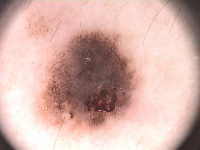</td><td>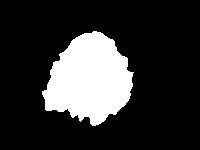</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# чтобы работала команда gdown:
!conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.11.0              |  py310hff52083_0         907 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_1          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.4.0              |       hb9d3cd8_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.16.1-pyhd8ed1ab_1 
  gdown              conda-forg

In [ ]:
# закомментирую тк работаю на kaggle
# ! gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [ ]:
# чтобы работал unrar:
# ! apt-get install unrar

In [ ]:
# закомментирую тк работаю на kaggle
# get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
# закачал датасет на kaggle
from pathlib import Path
DIR = Path('/kaggle/input/ph2dataset')

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
# os.walk создает итератор, который можно вызывать построчно.
# В результате мы получим соответствующий путь к папке и список всех файлов по этому пути

# x = os.path.join(root, files[0]) - соединяет в один path и ставит слэш

# root.endswith('_Dermoscopic_Image') - если строка заканчивается '...', то

# imread(x) - изображение по пути x превращается  в массив пикселей

In [ ]:
# создаём list с массивами пикселей картинок
images = []
lesions = []
from skimage.io import imread
import os
root = '/kaggle/input/ph2dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

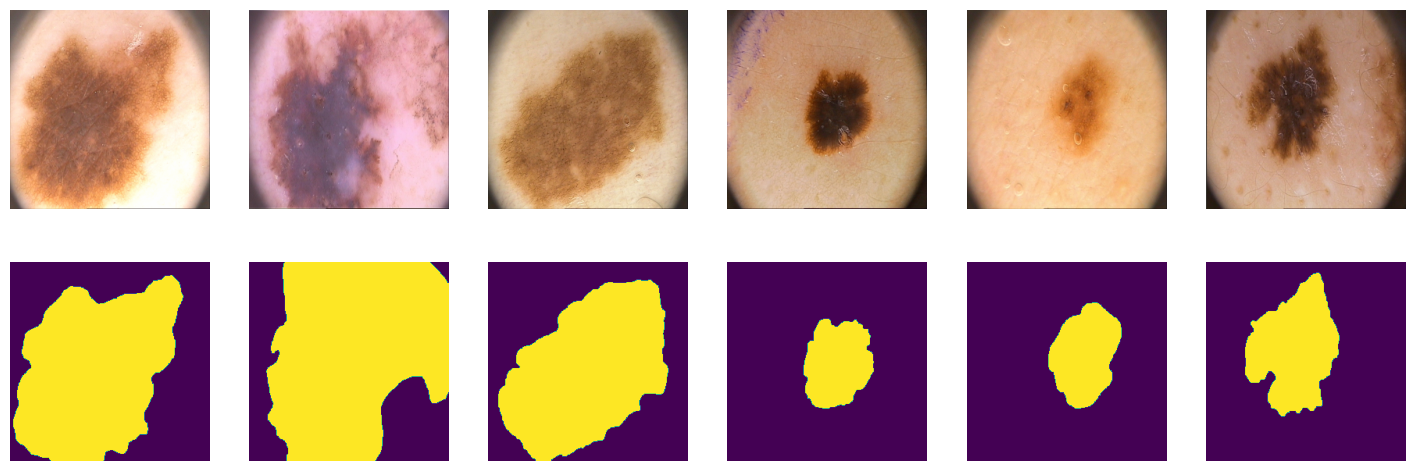

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
# перемешаем индексы и далее разделим array на 3 части
ix = np.random.choice(len(X), len(X), False)

# тут у нас три array с индексами. деление ix происходит по индексу 100 и индексу 150
tr, val, ts = np.split(ix, [100, 150])

## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:


In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]


Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real):
    # TODO
    loss = torch.sum(y_pred - (y_pred * y_real) + torch.log(1 + torch.exp(-y_pred)))
    return loss #/ (size[0] * size[1])


def bce_true(y_pred, y_real):
    # TODO с сигмоидой
    y_pred = torch.sigmoid(y_pred)
    loss = -1 * torch.sum(y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred))
    return loss

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss from bce_torch_with_logits = {bce_torch_with_logits(y_pred, y_true)}')
print(f'BCE loss from bce_true = {bce_true(y_pred, y_true)}')
print(f'BCE loss from bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')


BCE loss from scratch bce_loss = 3.870319366455078
BCE loss from bce_torch_with_logits = 3.870319366455078
BCE loss from bce_true = 3.870319128036499
BCE loss from bce_torch = 3.870319128036499


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss bce_true = {bce_true(y_pred, y_true)}')
print(f'BCE loss bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss bce_torch with logits = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss bce_loss = 13.821473121643066
BCE loss bce_true = 13.821473121643066
BCE loss bce_torch = 13.821473121643066
BCE loss bce_torch with logits = 13.821473121643066


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /kaggle/working/for_asserts/labels.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 3.57MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /kaggle/working/for_asserts/logits.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 6.28MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/kaggle/working/for_asserts'
dummpy_sample = {
    'logits': torch.load(f'{path_to_dummy_samples}/logits.pt', weights_only=False),
    'labels': torch.load(f'{path_to_dummy_samples}/labels.pt', weights_only=False)
}

dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

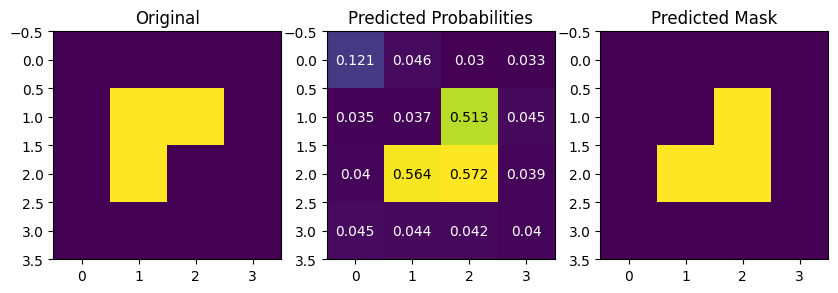

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10, 3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())

assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

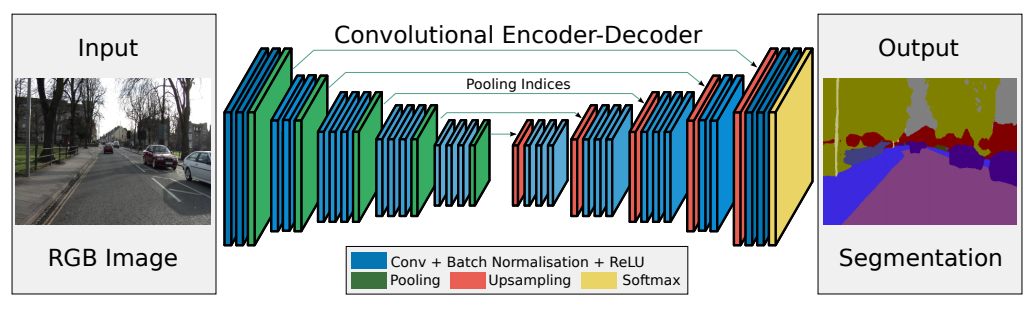

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SegNet, self).__init__()

        # VGG-16 architecture
        self.pooling = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.unsampling = nn.MaxUnpool2d(kernel_size=2)

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )


        # bottleneck
        # TODO
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )

        # Должно быть так:
        # self.bottleneck_conv = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU()
        # )


        # decoder (upsampling)
        self.decod_block_4 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.decod_block_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.decod_block_2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.decod_block_1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )


    def forward(self, x):
        # encoder
        # TOD
        e1, inds1 = self.pooling(self.conv_block_1(x))
        e2, inds2 = self.pooling(self.conv_block_2(e1))
        e3, inds3 = self.pooling(self.conv_block_3(e2))
        e4, inds4 = self.pooling(self.conv_block_4(e3))

        # bottleneck
        # TODO
        b = self.bottleneck_conv(e4)

        # decoder
        # TODO
        unsampling4 = self.unsampling(b, inds4)
        d4 = self.decod_block_4(unsampling4)
        unsampling3 = self.unsampling(d4, inds3)
        d3 = self.decod_block_3(unsampling3)
        unsampling2 = self.unsampling(d3, inds2)
        d2 = self.decod_block_2(unsampling2)
        unsampling1 = self.unsampling(d2, inds1)
        d1 = self.decod_block_1(unsampling1)

        return d1 # no activation

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train(model, train_dataloader, valid_dataloader, optimizer, criterion, epochs=10, scheduler=False, name_model='nn', plotting=False):    # TODO

    best_val_loss = float('inf')

    best_val_IOU = 0
    epoch_with_min_val_loss = 0

    history = []
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            if scheduler:
                scheduler.step()

            train_loss += loss.item() / len(train_dataloader)


        model.eval()
        avg_loss = 0
        avg_iou = 0
        with torch.no_grad():
            for x_batch, y_batch in tqdm(valid_dataloader):
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(x_batch)
                y_hat = y_pred.detach().cpu()
                loss = criterion(y_pred, y_batch)
                iou = iou_score(y_pred, y_batch)
                avg_loss += loss.item() / len(valid_dataloader)
                avg_iou += iou.item() / len(valid_dataloader)

        history.append((train_loss, avg_loss, avg_iou))

        if avg_iou > best_val_IOU:
            best_val_IOU = avg_iou

        # Visualize tools
        clear_output(wait=True)
        fig = plt.figure(figsize=(14, 7))

        for k in range(4):

            plt.subplot(4, 4, k+1)
            plt.imshow(np.rollaxis(x_batch[k].cpu().detach().numpy(), 0, 3), cmap='gray')
            plt.title('Real X')
            plt.axis('off')

            plt.subplot(4, 4, k+5)
            plt.imshow(y_batch[k, 0].cpu().detach().numpy(), cmap='gray')
            plt.title('Real Y')
            plt.axis('off')

            plt.subplot(4, 4, k+9)
            plt.imshow((y_hat[k, 0] > 0.5).int(), cmap='gray')
            plt.title('Output th 0.5')
            plt.axis('off')

            # plt.subplot(4, 4, k+13)
            # plt.imshow(y_hat[k, 0], cmap='gray')
            # plt.title('Output')
            # plt.axis('off')
        plt.show()

        print(f"Epoch  {epoch+1}   train_loss:  {train_loss:0.5f}   val_loss  {avg_loss:.5f}    val_iou  {avg_iou:.5f}")

        #
        ckpt_path = '/kaggle/working/'
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            epoch_with_min_val_loss = epoch + 1
            torch.save(model.state_dict(), f'{ckpt_path}/{name_model}_with_best_val_loss.pt')

    print(f'best_val_loss = {best_val_loss} in epoch = {epoch_with_min_val_loss}')


    def plotting_net(loss, val_loss, val_iou):
        fig, axes = plt.subplots(1, 2, figsize=(12, 3))
        axes[0].plot(loss, label="train_loss")
        axes[0].plot(val_loss, label="val_loss")
        axes[1].plot(val_iou, label="val_iou")
        for i in [0,1]: axes[i].legend()
        plt.show()

    if plotting:
        loss, val_loss, val_iou = zip(*history)
        plotting_net(loss, val_loss, val_iou)

    statistic = [epoch_with_min_val_loss, best_val_IOU]

    return model, statistic

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
criterion1 = nn.CrossEntropyLoss()                                       # loss = nan
criterion2 = bce_torch_with_logits
criterion3 = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)      # очень не стабилен - показатели сильно скачут
criterion4 = bce_loss
criterion5 = bce_true                    # (sigmoid(y_pred), y_real)

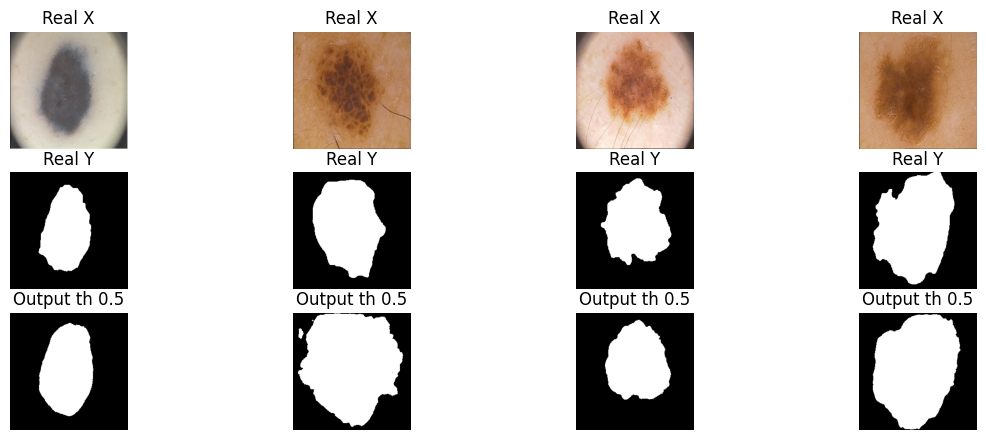

Epoch  30   train_loss:  229089.22187   val_loss  215430.27812    val_iou  0.79653
best_val_loss = 215430.27812499998 in epoch = 30


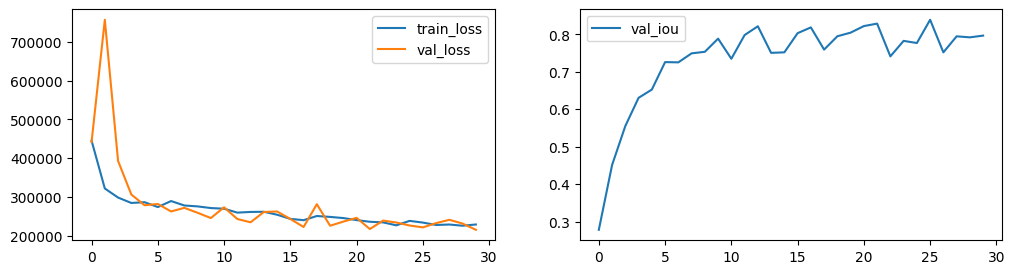

In [ ]:
torch.cuda.empty_cache()

segnet_bce_loss = SegNet().to(device)
# обучим
model, statistic = train(segnet_bce_loss, train_dataloader, valid_dataloader,
                         optimizer=torch.optim.AdamW(segnet_bce_loss.parameters(), lr=1e-3, betas=(0.9, 0.999)),
                         criterion=bce_loss,
                         epochs=30,
                         name_model='segnet_bce_loss', plotting=True)

In [ ]:
# хочу посмотреть сколько параметров и вес
# ! pip install torchsummary
# from torchsummary import summary
#summary(segnet_model_with_bce_loss, (3, 224, 224))

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test_score(model, data, criterion, path):
    # TODO
    model.load_state_dict(torch.load(path, weights_only=False))
    model.eval()
    test_loss = 0
    test_iou = 0
    with torch.no_grad():
        for x_batch, y_batch in data:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = model(x_batch)
            test_loss += criterion(y_pred, y_batch).item() / len(data)
            test_iou += iou_score(y_pred, y_batch).item() / len(data)

    print(f'{path} :\n    test_loss = {test_loss},  test_iou = {test_iou}')

    return [test_iou, test_loss]


In [ ]:
# глянем на метрики на тестовых данных
test_metrics = test_score(segnet_bce_loss, test_dataloader, bce_loss, 'segnet_bce_loss_with_best_val_loss.pt')

# добавим их в статистику по данной модели
statistic += test_metrics

segnet_bce_loss_with_best_val_loss.pt :
    test_loss = 210080.659375,  test_iou = 0.7972779989242553


In [ ]:
import pandas as pd
# создадим датафрейм, в который будем собирать метрики по каждой модели
statistics = pd.DataFrame(index=[
    'epoch_min_val_loss',
    'best_val_IOU',
    'test_IOU',
    'test_LOSS'
])

# добавим в табличку первую колонку
statistics['segnet_bce_loss'] = statistic
statistics

,segnet_bce_loss
epoch_min_val_loss,30.000000
best_val_IOU,0.838809
test_IOU,0.797278
test_LOSS,210080.659375


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.

### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    # TODO
    eps = 1e-8
    logits = (torch.sigmoid(logits) > threshold).float()
    TP = (logits * labels).sum()
    FP = logits.sum() - TP
    FN = labels.sum() - TP
    dice_sc = (2. * TP + eps) / (2. * TP + FP + FN + eps)

    return dice_sc

In [ ]:
dice_score(dummpy_sample['logits'], dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    # TODO
    eps=1e-8
    logits = torch.sigmoid(logits)
    TP = (logits * labels).sum()
    FP = logits.sum() - TP
    FN = labels.sum() - TP
    dice = (2. * TP + eps) / (2. * TP + FP + FN + eps)
    loss = 1 - dice

    return loss

Проверка на корректность:

In [ ]:
! pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2a662b67e52a3c2de020d26ab2fb7683804a7b55c17dbd0e6e36df14fe9bbbfa
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=f8f70e1a910885365b8205c0f982aa580c4ff0d55bb6d6c069b8a056d90bb95d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_pred, y_real, eps=1e-6, gamma=1, alpha=-1):
    # TODO
    # FL(pt) = −α(1−pt)γ⋅log(pt)
    y_pred = torch.sigmoid(y_pred)
    # Избегаем деления на ноль
    y_pred = torch.clamp(input=y_pred, min=eps, max=1-eps)
    BCE = -(y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred))
    p_t = y_pred * y_real + (1 - y_pred) * (1 - y_real)

    loss = (1 - p_t) ** gamma * BCE
    return torch.mean(loss)

In [ ]:
focal_loss(dummpy_sample['logits'], dummpy_sample['labels']).item()

0.2674769163131714

# Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=1, reduction='mean').item()

0.2674769163131714

In [ ]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=1, reduction='mean') == focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=1)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [ ]:
def tversky_loss(y_pred, y_true, alpha=0.5, beta=0.5, eps=1e-8):
    y_pred = torch.sigmoid(y_pred)
    intersection = (y_pred * y_true).sum()
    fps = (y_pred * (1 - y_true)).sum()
    fns = ((1 - y_pred) * y_true).sum()
    denom = intersection + (alpha * fps) + (beta * fns)
    tversky_loss = torch.mean((intersection + eps) / (denom + eps))
    return (1 - tversky_loss)

In [ ]:
tversky_loss(dummpy_sample['logits'], dummpy_sample['labels']).item()

0.5755997896194458

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.


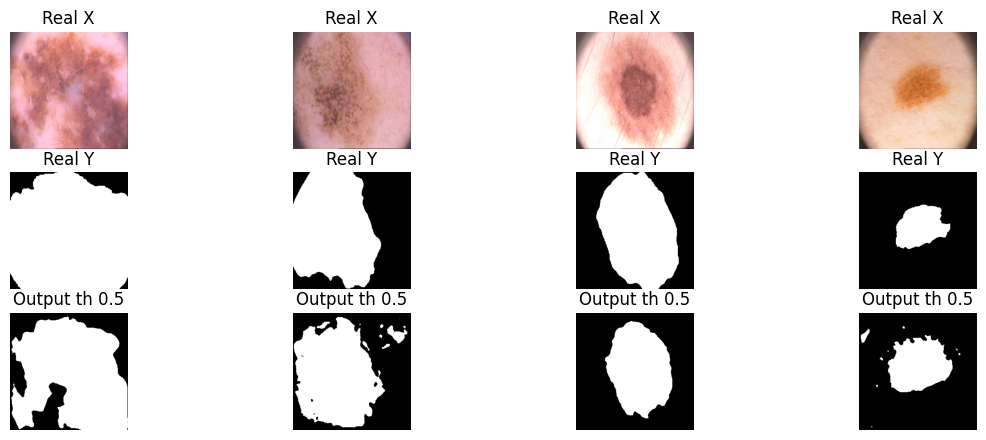

Epoch  30   train_loss:  0.37335   val_loss  0.35572    val_iou  0.66829
best_val_loss = 0.2852316737174988 in epoch = 22


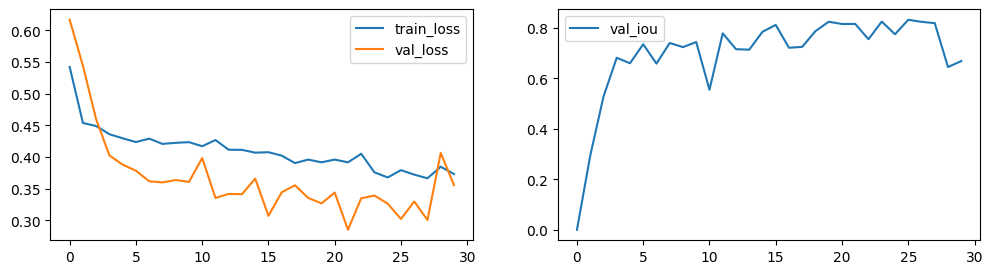

segnet_dice_loss_with_best_val_loss.pt :
    test_loss = 0.3039835929870605,  test_iou = 0.8047248721122742


In [ ]:
torch.cuda.empty_cache()

segnet_dice_loss = SegNet().to(device)
# обучим
model, statistic = train(segnet_dice_loss, train_dataloader, valid_dataloader,
                         optimizer=torch.optim.AdamW(segnet_dice_loss.parameters(), lr=1e-3, betas=(0.9, 0.999)),
                         criterion=dice_loss,
                         epochs=30,
                         name_model='segnet_dice_loss', plotting=True)

# посмотрим на метрики на тесте
test_metrics = test_score(segnet_dice_loss, test_dataloader, dice_loss, 'segnet_dice_loss_with_best_val_loss.pt')

# собираем метрики вместе и добавляем в итоговую таблицу
statistic += test_metrics
statistics['segnet_dice_loss'] = statistic

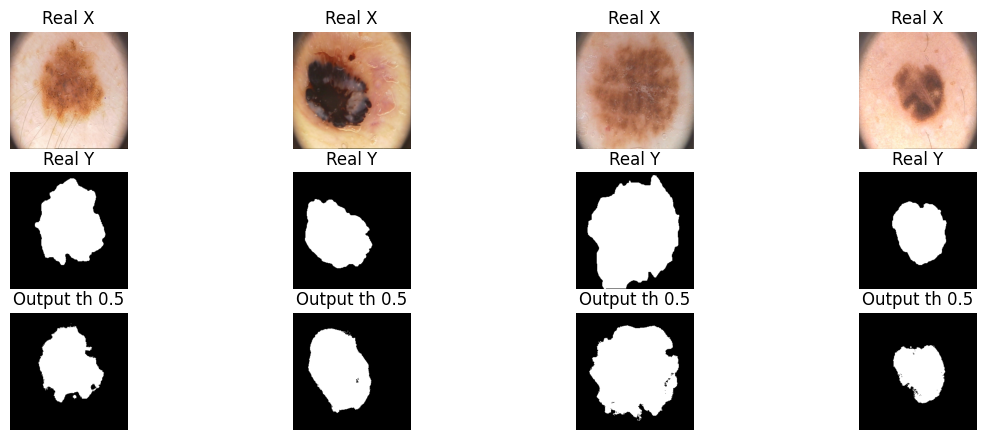

Epoch  30   train_loss:  0.14750   val_loss  0.14868    val_iou  0.76215
best_val_loss = 0.13193672448396682 in epoch = 24


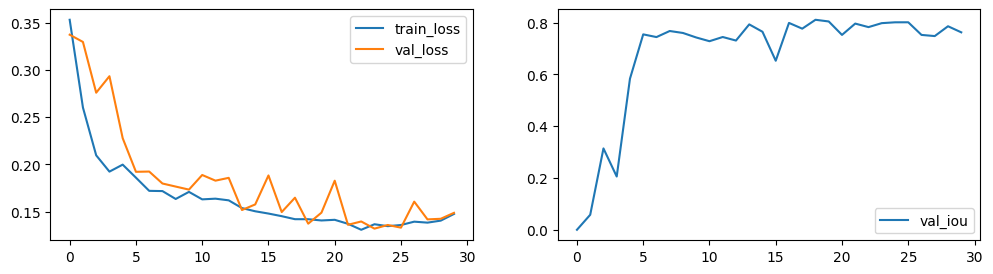

segnet_focal_loss_with_best_val_loss.pt :
    test_loss = 0.13892684280872344,  test_iou = 0.7769084453582763


In [ ]:
torch.cuda.empty_cache()

segnet_focal_loss = SegNet().to(device)
# обучим
model, statistic = train(segnet_focal_loss, train_dataloader, valid_dataloader,
                         optimizer=torch.optim.AdamW(segnet_focal_loss.parameters(), lr=1e-3, betas=(0.9, 0.999)),
                         criterion=focal_loss,
                         epochs=30,
                         name_model='segnet_focal_loss', plotting=True)

# посмотрим на метрики на тесте
test_metrics = test_score(segnet_focal_loss, test_dataloader, focal_loss, 'segnet_focal_loss_with_best_val_loss.pt')

# собираем метрики вместе и добавляем в итоговую таблицу
statistic += test_metrics
statistics['segnet_focal_loss'] = statistic

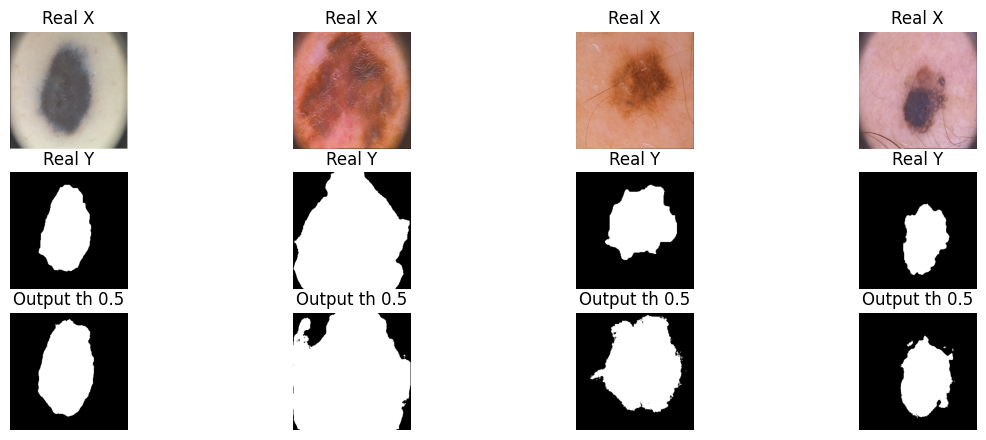

Epoch  30   train_loss:  0.37892   val_loss  0.29413    val_iou  0.79407
best_val_loss = 0.294134783744812 in epoch = 30


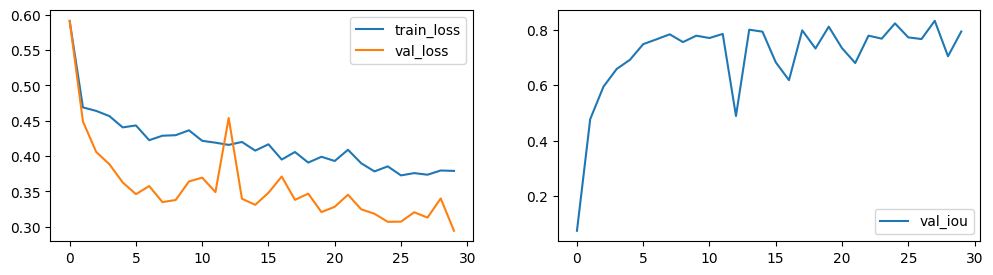

segnet_tversky_loss_with_best_val_loss.pt :
    test_loss = 0.31553035974502563,  test_iou = 0.7788215637207032


In [ ]:
torch.cuda.empty_cache()

segnet_tversky_loss = SegNet().to(device)
# обучим
model, statistic = train(segnet_tversky_loss, train_dataloader, valid_dataloader,
                         optimizer=torch.optim.AdamW(segnet_tversky_loss.parameters(), lr=1e-3, betas=(0.9, 0.999)),
                         criterion=tversky_loss,
                         epochs=30,
                         name_model='segnet_tversky_loss', plotting=True)

# посмотрим на метрики на тесте
test_metrics = test_score(segnet_tversky_loss, test_dataloader, tversky_loss, 'segnet_tversky_loss_with_best_val_loss.pt')
# собираем метрики вместе и добавляем в итоговую таблицу
statistic += test_metrics
statistics['segnet_tversky_loss'] = statistic

(batch_size=10, epochs=30)

При каком лоссе модель сходится быстрее?
- из трёх моделей лидирует модель с dice_loss, показавшая минимальный train loss на 22 эпохе

При каком лоссе модель выдает наилучшую метрику?

- dice loss также показал и лучшую метрику test_iou = 0.8047, однако bce loss "дышет ему в спину"

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

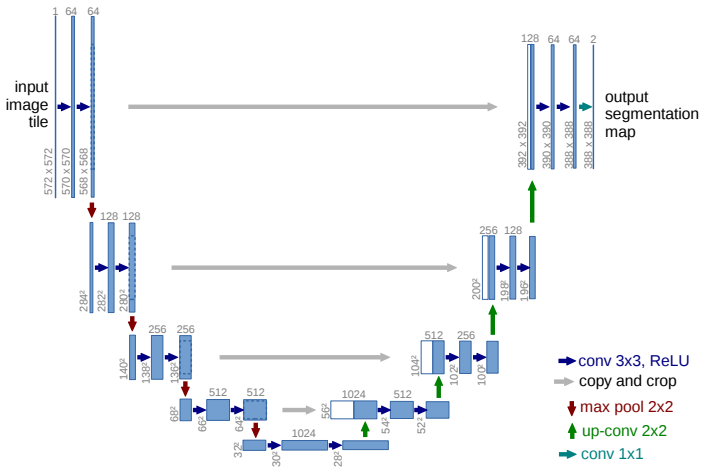

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
torch.cuda.empty_cache()

class UNet(nn.Module):
    def __init__(self, n_class=1):
        super(UNet, self).__init__()

        # encoder
        self.encoder_block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.encoder_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )

        self.encoder_block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )

        self.encoder_block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )

        # decoder (upsampling)
        self.decoder_block_4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.decoder_block_3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.decoder_block_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.decoder_block_1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, n_class, kernel_size=1),
            nn.BatchNorm2d(n_class)
            #nn.Sigmoid()
        )

        self.maxpooling = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.unpooling = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x):
        # encoder
        encod1 = self.encoder_block_1(x)          # 256x256x64
        pool1, inds1 = self.maxpooling(encod1)    # 128x128x64
        encod2 = self.encoder_block_2(pool1)      # 128x128x128
        pool2, inds2 = self.maxpooling(encod2)    # 64x64x128
        encod3 = self.encoder_block_3(pool2)      # 64x64x256
        pool3, inds3 = self.maxpooling(encod3)    # 32x32x256
        encod4 = self.encoder_block_4(pool3)      # 32x32x512
        pool4, inds4 = self.maxpooling(encod4)    # 16x16x512

        # bottleneck
        b = self.bottleneck_conv(pool4)           # 16x16x512

        # decoder
        unpooling = self.unpooling(b, inds4)             # 32x32x512
        concat = torch.cat((unpooling, encod4), dim=1)   # 32x32x1024
        d4 = self.decoder_block_4(concat)                # 32x32x256

        unpooling = self.unpooling(d4, inds3)            # 64x64x256
        concat = torch.cat((unpooling, encod3), dim=1)   # 64x64x512
        d3 = self.decoder_block_3(concat)                # 64x64x128

        unpooling = self.unpooling(d3, inds2)            # 128x128x128
        concat = torch.cat((unpooling, encod2), dim=1)   # 128x128x256
        d2 = self.decoder_block_2(concat)                # 128x128x64

        unpooling = self.unpooling(d2, inds1)            # 256x256x64
        concat = torch.cat((unpooling, encod1), dim=1)   # 256x256x128
        d1 = self.decoder_block_1(concat)                # 256x256 x n_class

        return d1 # no activation

In [ ]:
# unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.


обучим unet model with bce_loss

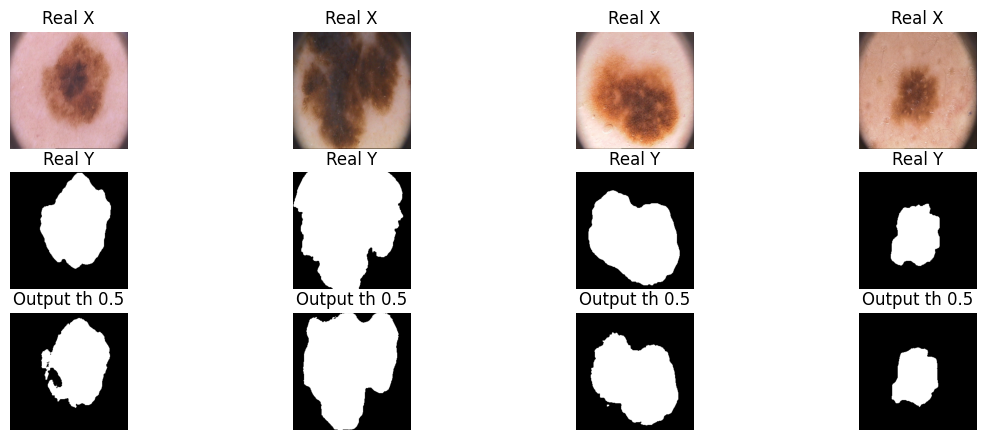

Epoch  30   train_loss:  217624.29062   val_loss  208327.03438    val_iou  0.84690
best_val_loss = 203013.0 in epoch = 29


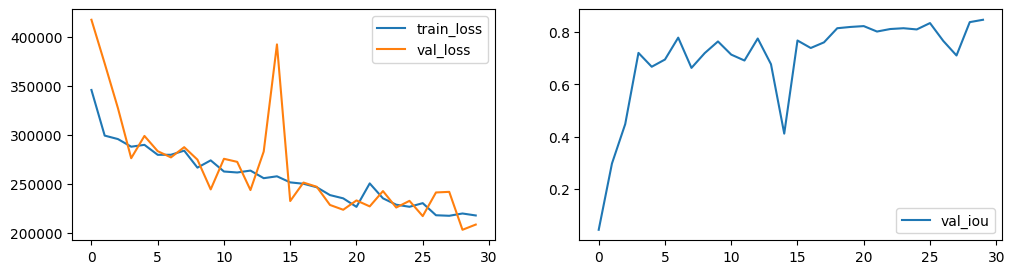

unet_bce_loss_with_best_val_loss.pt :
    test_loss = 205570.625,  test_iou = 0.8217821478843688


In [ ]:
torch.cuda.empty_cache()

unet_bce_loss = UNet().to(device)
# обучим
model, statistic = train(unet_bce_loss, train_dataloader, valid_dataloader,
                         optimizer=torch.optim.AdamW(unet_bce_loss.parameters(), lr=1e-3, betas=(0.9, 0.999)),
                         criterion=bce_loss,
                         epochs=30,
                         name_model='unet_bce_loss', plotting=True)

# посмотрим на метрики на тесте
test_metrics = test_score(unet_bce_loss, test_dataloader, bce_loss, 'unet_bce_loss_with_best_val_loss.pt')
# собираем метрики вместе и добавляем в итоговую таблицу
statistic += test_metrics
statistics['unet_bce_loss'] = statistic

обучим unet model with dice_loss

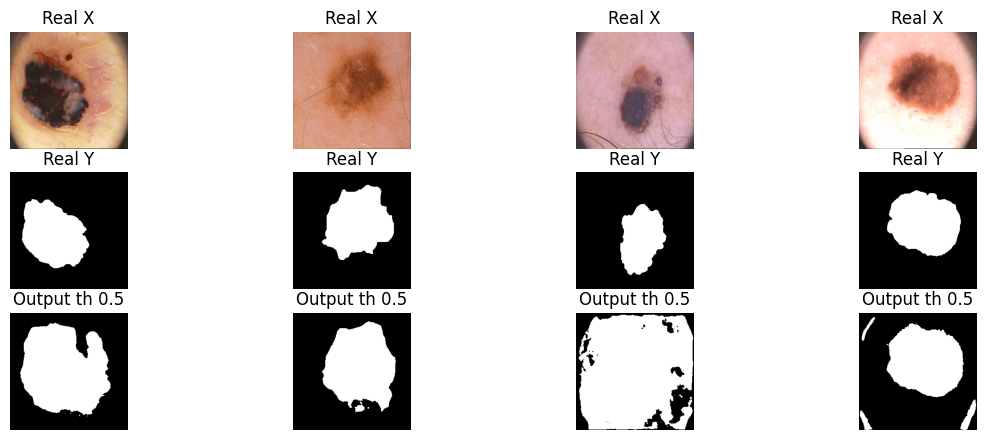

Epoch  30   train_loss:  0.37302   val_loss  0.32029    val_iou  0.73267
best_val_loss = 0.28462523221969604 in epoch = 27


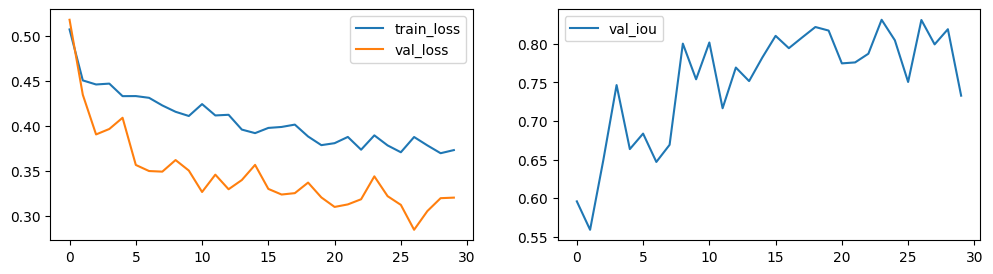

unet_dice_loss_with_best_val_loss.pt :
    test_loss = 0.3050256252288818,  test_iou = 0.821256685256958


In [ ]:
torch.cuda.empty_cache()

unet_dice_loss = UNet().to(device)
# обучим
model, statistic = train(unet_dice_loss, train_dataloader, valid_dataloader,
                         optimizer=torch.optim.AdamW(unet_dice_loss.parameters(), lr=1e-3, betas=(0.9, 0.999)),
                         criterion=dice_loss,
                         epochs=30,
                         name_model='unet_dice_loss', plotting=True)

# посмотрим на метрики на тесте
test_metrics = test_score(unet_dice_loss, test_dataloader, dice_loss, 'unet_dice_loss_with_best_val_loss.pt')
# собираем метрики вместе и добавляем в итоговую таблицу
statistic += test_metrics
statistics['unet_dice_loss'] = statistic

обучим unet model with focal_loss

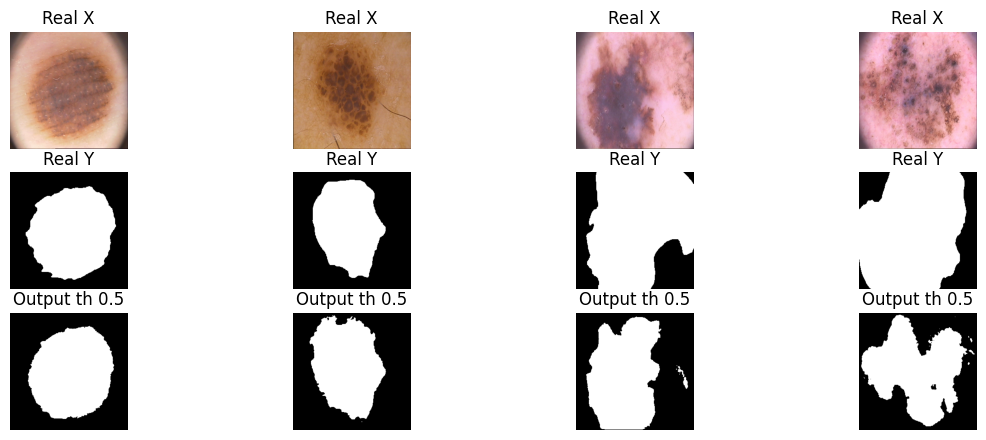

Epoch  30   train_loss:  0.12499   val_loss  0.10617    val_iou  0.85625
best_val_loss = 0.1061684787273407 in epoch = 30


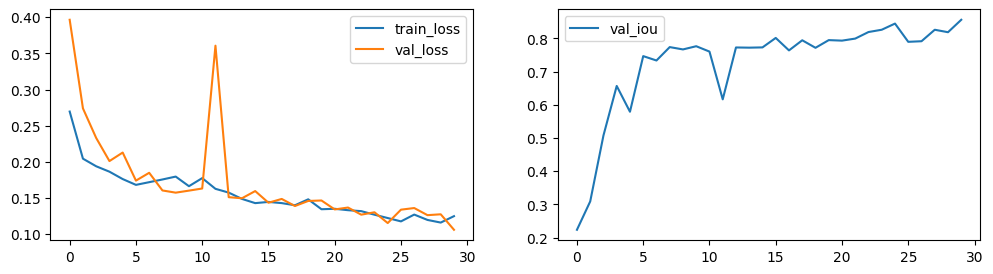

unet_focal_loss_with_best_val_loss.pt :
    test_loss = 0.11230668127536775,  test_iou = 0.8333691000938416


In [ ]:
torch.cuda.empty_cache()

unet_focal_loss = UNet().to(device)
# обучим
model, statistic = train(unet_focal_loss, train_dataloader, valid_dataloader,
                         optimizer=torch.optim.AdamW(unet_focal_loss.parameters(), lr=1e-3, betas=(0.9, 0.999)),
                         criterion=focal_loss,
                         epochs=30,
                         name_model='unet_focal_loss', plotting=True)

# посмотрим на метрики на тесте
test_metrics = test_score(unet_focal_loss, test_dataloader, focal_loss, 'unet_focal_loss_with_best_val_loss.pt')
# собираем метрики вместе и добавляем в итоговую таблицу
statistic += test_metrics
statistics['unet_focal_loss'] = statistic

In [ ]:
# выведем результирующую таблицу и подведем итоги
statistics.style.set_table_styles([{'selector': 'td',
                                    'props': [('font-size', '12pt'),('border-style','solid'),('border-width','1px')]}])

,segnet_bce_loss,segnet_dice_loss,segnet_focal_loss,segnet_tversky_loss,unet_bce_loss,unet_dice_loss,unet_focal_loss
epoch_min_val_loss,30.000000,22.000000,24.000000,30.000000,29.000000,27.000000,30.000000
best_val_IOU,0.838800,0.831800,0.810600,0.832900,0.846900,0.830900,0.856300
test_IOU,0.797300,0.804700,0.776900,0.778800,0.821800,0.821300,0.833400
test_LOSS,210080.659400,0.304000,0.138900,0.315500,205570.625000,0.305000,0.112300


(batch_size=10, epochs=30)

Сравните визуально результаты SegNet и UNet.

1. Какая модель дает лучшие значения по метрике?
- В целом можно заметить, что модель UNet показала лучшие результаты, чем SegNet. Лучшую метрику показала нейросеть UNet с focal loss (iou на тесте = 0.833)

2. Какая модель дает лучшие значения по лоссам?
- по лоссам тоже лидирует UNet с focal loss (loss на тесте = 0.1123)

3. Какая модель обучается быстрее?
- сетка SegNet с dice_loss показала минимальный лосс на 22 эпохе из 30